In [1]:
import os
os.chdir('../src')

from molecular_cloud_initialization import *
from plotters import *
from cluster_cloud_initialization import *


import numpy as np
import matplotlib.pyplot as plt
from amuse.community.fi.interface import Fi
from amuse.lab import Particles, nbody_system
from amuse.couple import bridge
from amuse.units import units
from amuse.community.bhtree.interface import Bhtree
from amuse.ext.sink import new_sink_particles



In [2]:
tot_cloud_mass = 4/3 *units.constants.pi * (15 | units.pc)**3 * ( 2.3 | units.amu * 10 / (units.cm**3))
print(tot_cloud_mass.value_in(units.MSun))

#Assmuing a pure molecular hydrogen cloud, with typical density around 85 molecules per cm^-3, calculate the approximate cloud mass based on
#cloud size. 50 pc is selected for a small GC of only 100 stars. 

7975.78734729


In [3]:
# initialise and evolve the MC particle set
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 200_000,
                                                         M_cloud = 8_000 | units.MSun,
                                                         R_cloud = 15 | units.pc,
                                                         seed = 1312)

particles_cloud, density_map = evolve_molecular_cloud(particles_cloud, 
                                                    converter_cloud, 
                                                    t_end = 2 | units.Myr, 
                                                    dt = 0.2 | units.Myr, 
                                                    seed = 1312)

print("Mean density of the moelcular cloud", np.mean(particles_cloud.density))

In [ ]:
star_cluster = make_globular_cluster(star_count = 100,
                                    imf = "kroupa", 
                                    metallicity = 0.002, 
                                    age = 10 | units.Gyr, 
                                    seed = 1312)

In [6]:
def hydro_code(Code, dt, converter, particles, seed):
    '''
    This function contains the parameters we want to initialise the 
    hydro code with. (hard Coded)
    '''
    
    np.random.seed(seed)

    hydro = Code(converter)
    hydro.parameters.use_hydro_flag = True # Hydrodynamics flag. True means:
                            # SPH hydro included, False means: gravity only.
    hydro.parameters.gamma = 1 # gas polytropic index (1.6666667)
                        # (default value:1.6666667). In this case-> Ideal Gas   
    hydro.parameters.timestep = dt
    hydro.parameters.eps_is_h_flag = True # Default value
    hydro.parameters.radiation_flag = False # turns off radiatiative cooling/heat.
    hydro.parameters.isothermal_flag = True  # Isothermal flag. True means:
                # isothermal gas (requires integrate_entropy_flag == False)
    hydro.parameters.integrate_entropy_flag = False #True means: integrate
                                          # entropy, else: internal energy. 
    hydro.gas_particles.add_particles(particles) # add the particles
   
    return hydro    

In [7]:
# initialise the star particle set
star = Particles(1)
star.name = "star"
star.mass = 0.7 |units.MSun
star.radius = star.mass[0].value_in(units.MSun)**0.8 | units.RSun
star.position = (-1.0, 0, 0) * (17 | units.pc)
star.velocity = (1.0, 0, 0) * (20| units.kms)
inital_mass = np.copy(star.mass)
converter_star = nbody_system.nbody_to_si(star.mass.sum(), 
                                   star.position.sum())

In [8]:
#initiate the gravity code with sink particles
gravity_code = Bhtree(converter_star)
sink = new_sink_particles(star)

gravity_code.particles.add_particles(sink)

In [9]:
# #start the hydro code for the gas
hydro_cloud = hydro_code(Code = Fi, dt = 0.1 | units.Myr,
                         converter = converter_cloud,
                         particles = particles_cloud,
                         seed = 1312)


channel = {"to_sink": gravity_code.particles.new_channel_to(sink),
           "from_sink": sink.new_channel_to(gravity_code.particles),
           "to_cloud": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "from_cloud": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

In [10]:
gravhydrobridge = bridge.Bridge(use_threading = False)
gravhydrobridge.add_system(gravity_code, (hydro_cloud,) )
gravhydrobridge.add_system(hydro_cloud, (gravity_code,) )
gravhydrobridge.timestep = 0.1 | units.Myr

In [11]:
def bondi_radius(stellar_mass):
    sound_speed = 0.2 | units.kms
    R = 2 * units.constants.G * stellar_mass /(sound_speed **2)

    return R

def bondi_accretion_rate(rho,v,r):
    dM = units.constants.pi * (r**2) * rho * v

    return dM

In [12]:
print((bondi_radius(sink.mass[0])).value_in(units.pc))

0.150570272486


In [13]:
print(len(particles_cloud.mass))
print(particles_cloud.mass.sum().value_in(units.MSun))
print(sink.mass)

203681
8000.0
[0.7] MSun


Sink radius [0.150570272486] parsec
Sink in progress at 0.1  Myr. Now located at [-14.95404246]
post accretion 0.7 MSun
203681 number of cloud particles now


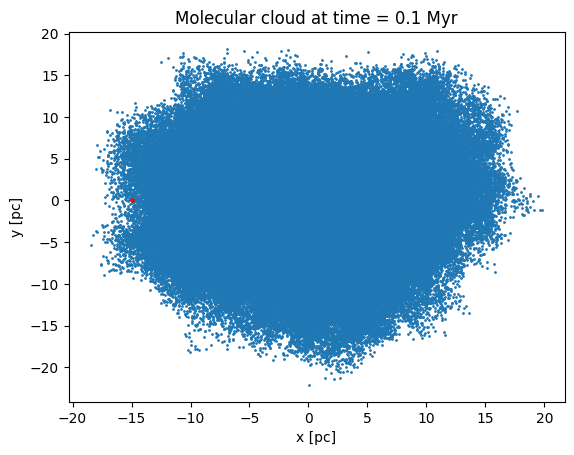

Sink radius [0.150570272486] parsec
Sink in progress at 0.2  Myr. Now located at [-12.90676904]
post accretion 0.7 MSun
203681 number of cloud particles now


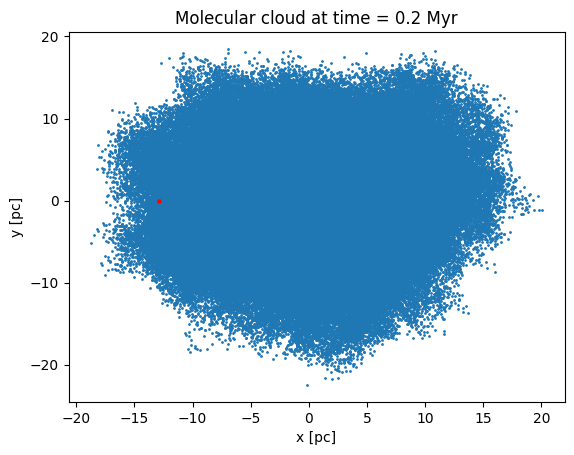

Sink radius [0.150570272486] parsec
Sink in progress at 0.30000000000000004  Myr. Now located at [-10.85813866]
post accretion 0.7 MSun
203681 number of cloud particles now


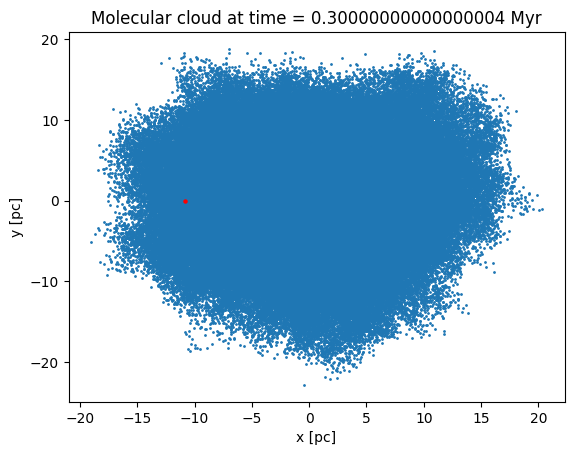

Sink radius [0.150570272486] parsec
Sink in progress at 0.4  Myr. Now located at [-8.8082742]
post accretion 0.739277104885 MSun
203680 number of cloud particles now


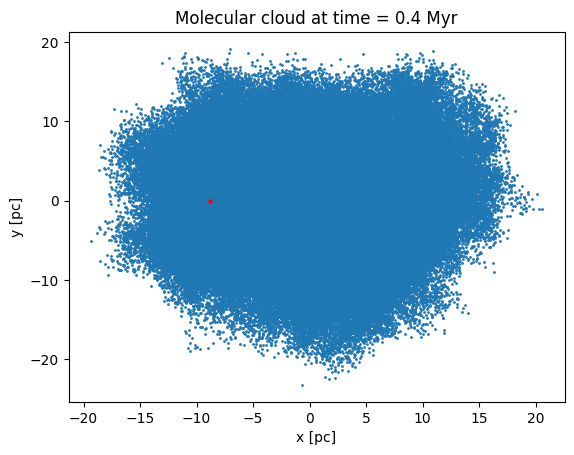

Sink radius [0.159018793035] parsec
Sink in progress at 0.5  Myr. Now located at [-6.864708]
post accretion 0.739277104885 MSun
203680 number of cloud particles now


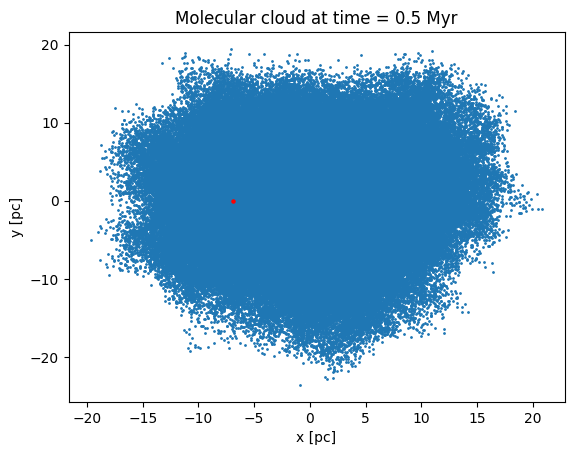

Sink radius [0.159018793035] parsec
Sink in progress at 0.6  Myr. Now located at [-4.92241649]
post accretion 0.739277104885 MSun
203680 number of cloud particles now


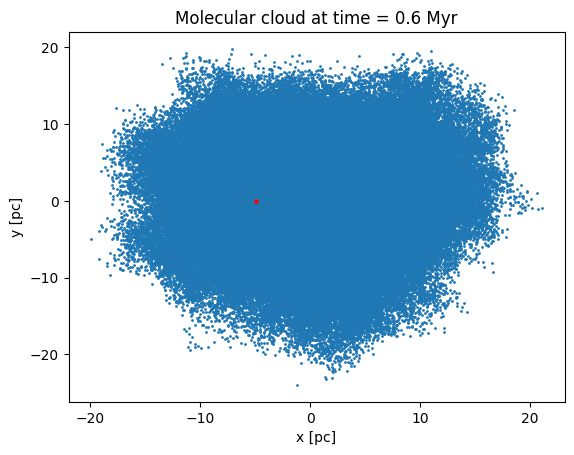

Sink radius [0.159018793035] parsec
Sink in progress at 0.7  Myr. Now located at [-2.97945752]
post accretion 0.739277104885 MSun
203680 number of cloud particles now


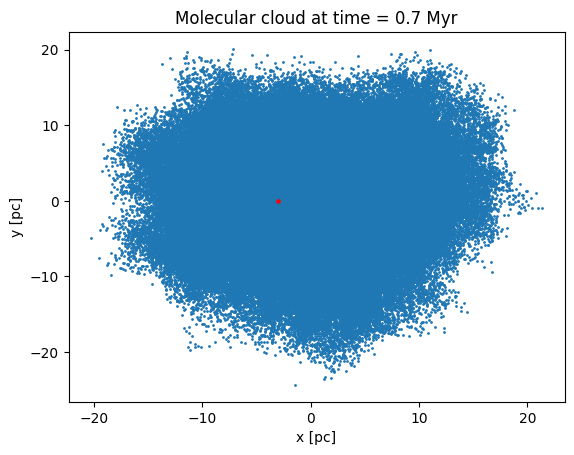

Sink radius [0.159018793035] parsec
Sink in progress at 0.7999999999999999  Myr. Now located at [-1.03608287]
post accretion 0.739277104885 MSun
203680 number of cloud particles now


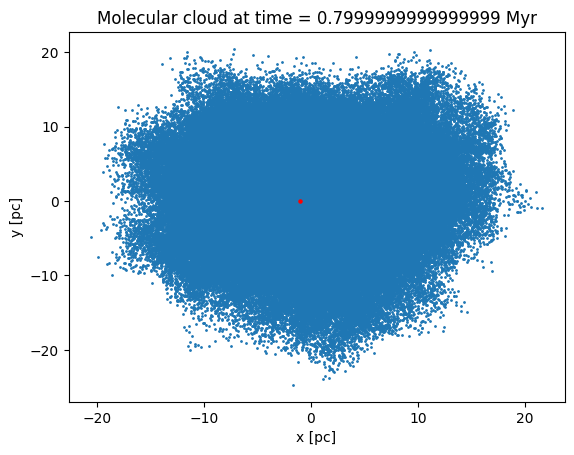

Sink radius [0.159018793035] parsec
Sink in progress at 0.8999999999999999  Myr. Now located at [ 0.90739111]
post accretion 0.857108419538 MSun
203677 number of cloud particles now


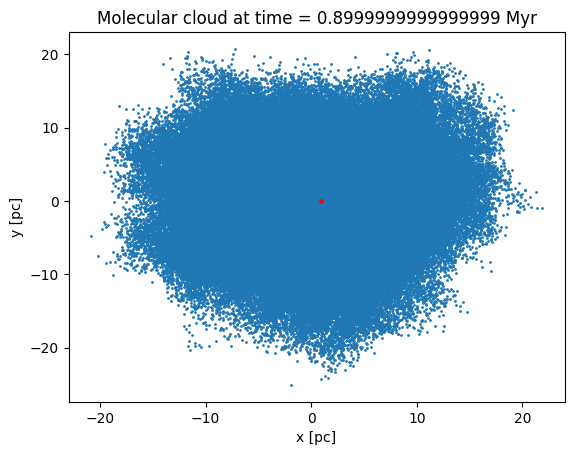

Sink radius [0.184364354685] parsec
Sink in progress at 0.9999999999999999  Myr. Now located at [ 2.57742237]
post accretion 0.857108419538 MSun
203677 number of cloud particles now


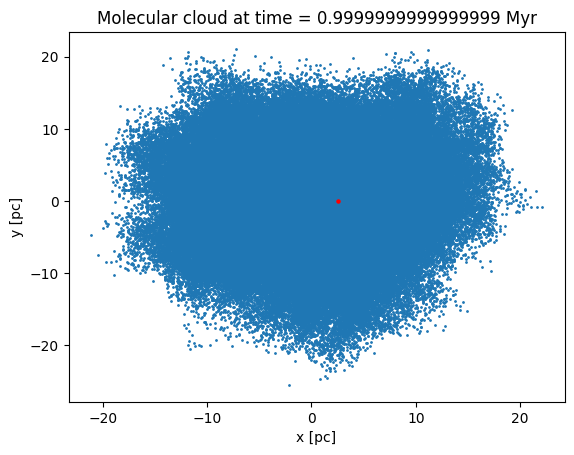

Sink radius [0.184364354685] parsec
Sink in progress at 1.0999999999999999  Myr. Now located at [ 4.25441026]
post accretion 0.857108419538 MSun
203677 number of cloud particles now


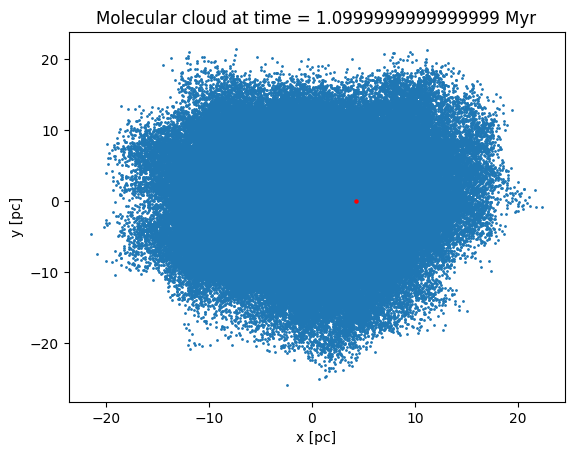

Sink radius [0.184364354685] parsec
Sink in progress at 1.2  Myr. Now located at [ 5.9308874]
post accretion 0.857108419538 MSun
203677 number of cloud particles now


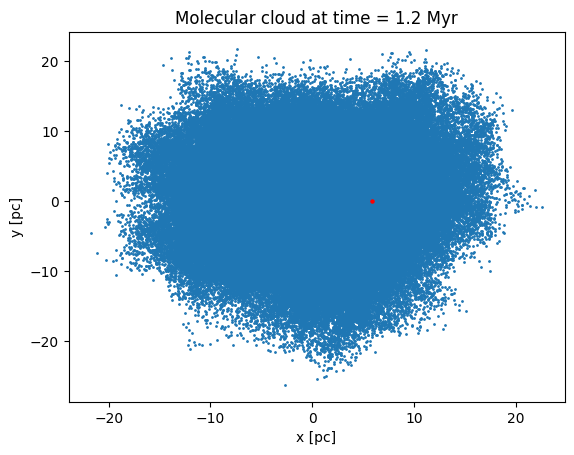

Sink radius [0.184364354685] parsec
Sink in progress at 1.3  Myr. Now located at [ 7.60662574]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


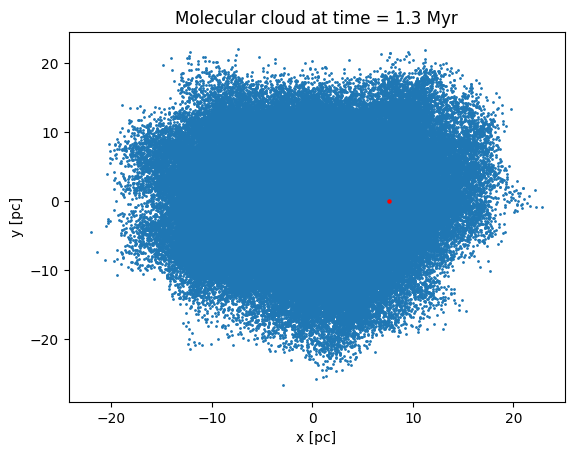

Sink radius [0.192812875235] parsec
Sink in progress at 1.4000000000000001  Myr. Now located at [ 9.21219211]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


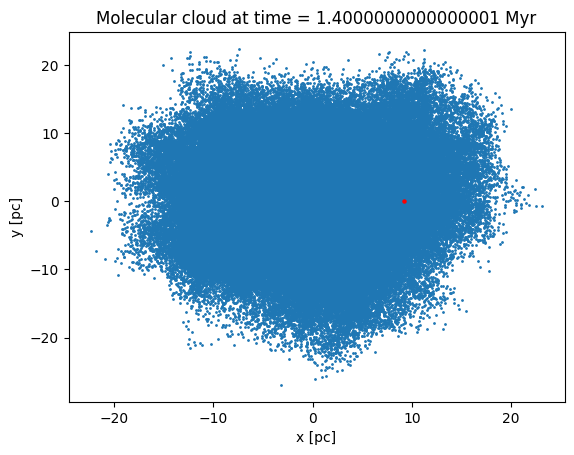

Sink radius [0.192812875235] parsec
Sink in progress at 1.5000000000000002  Myr. Now located at [ 10.81708946]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


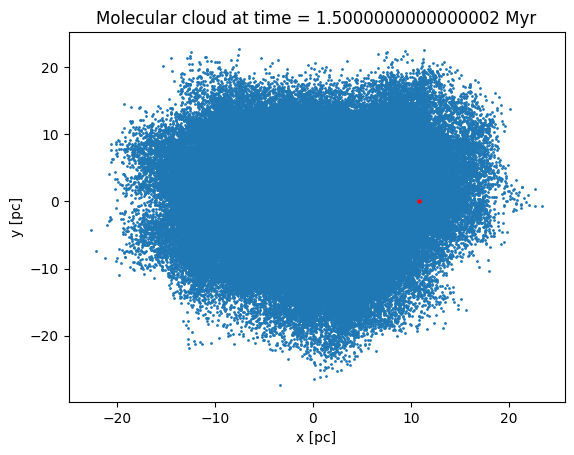

Sink radius [0.192812875235] parsec
Sink in progress at 1.6000000000000003  Myr. Now located at [ 12.42066774]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


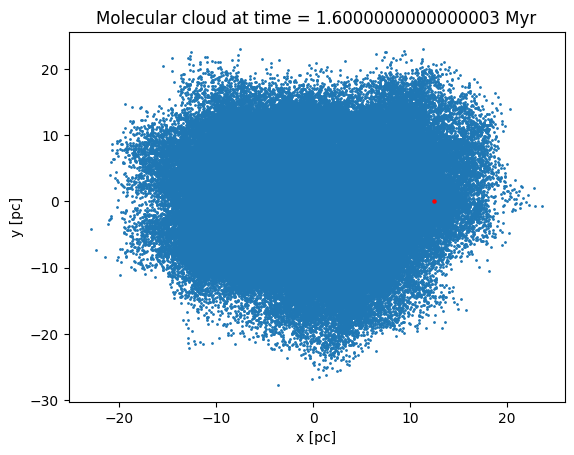

Sink radius [0.192812875235] parsec
Sink in progress at 1.7000000000000004  Myr. Now located at [ 14.02288554]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


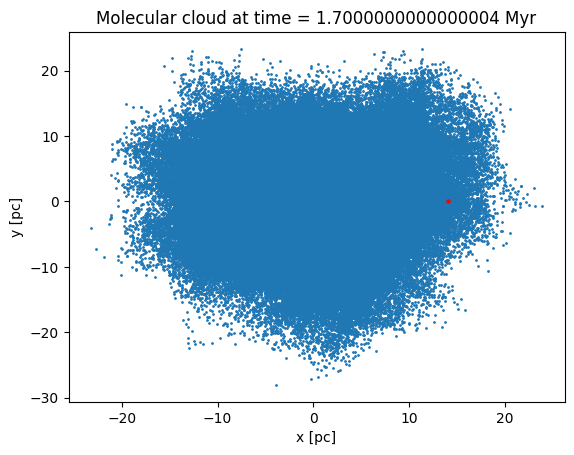

Sink radius [0.192812875235] parsec
Sink in progress at 1.8000000000000005  Myr. Now located at [ 15.62379546]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


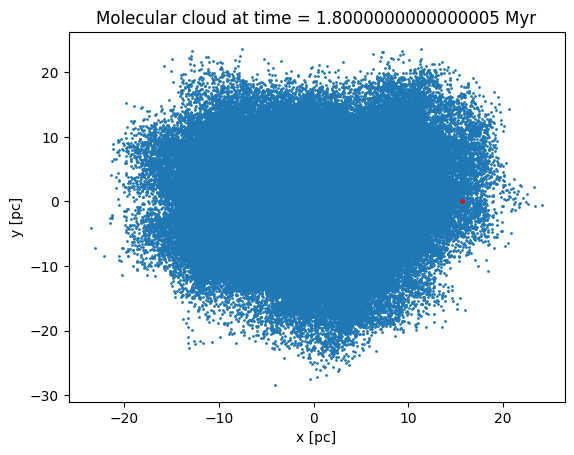

Sink radius [0.192812875235] parsec
Sink in progress at 1.9000000000000006  Myr. Now located at [ 17.22349939]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


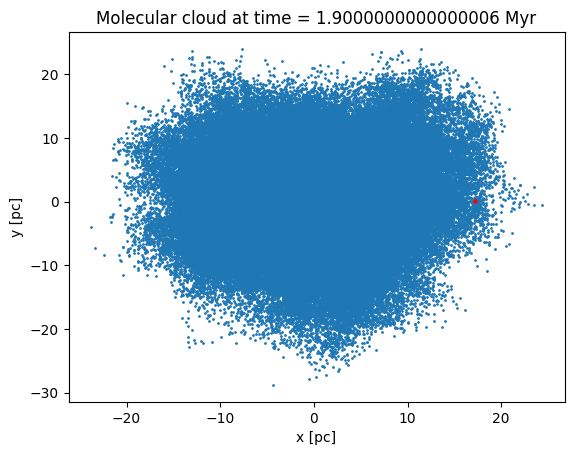

Sink radius [0.192812875235] parsec
Sink in progress at 2.0000000000000004  Myr. Now located at [ 18.82211821]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


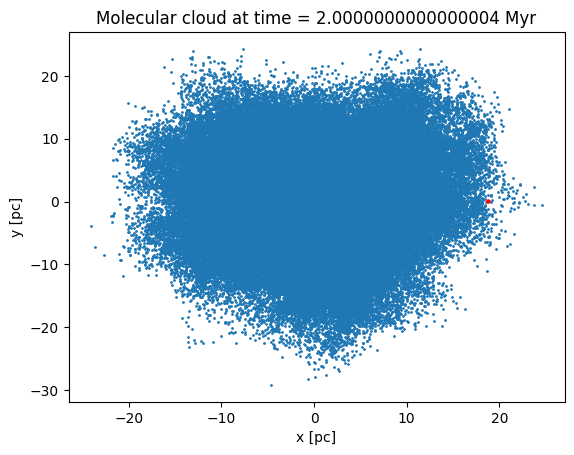

Sink radius [0.192812875235] parsec
Sink in progress at 2.1000000000000005  Myr. Now located at [ 20.4197812]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


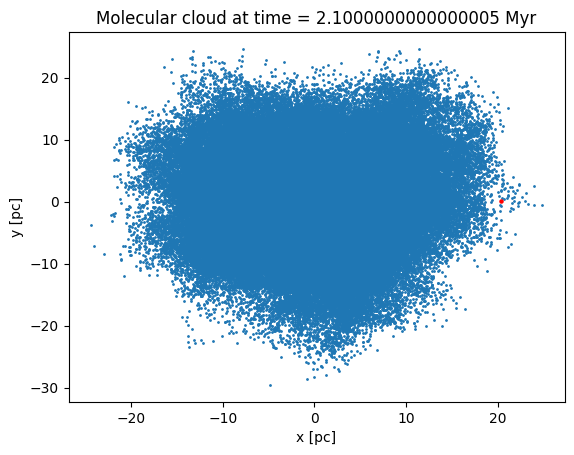

Sink radius [0.192812875235] parsec
Sink in progress at 2.2000000000000006  Myr. Now located at [ 22.01661269]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


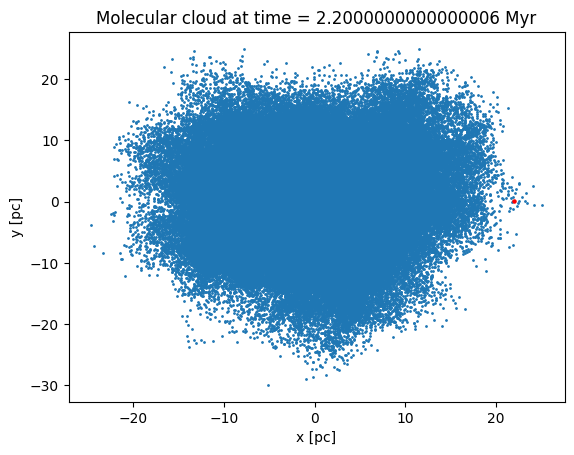

Sink radius [0.192812875235] parsec
Sink in progress at 2.3000000000000007  Myr. Now located at [ 23.61272122]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


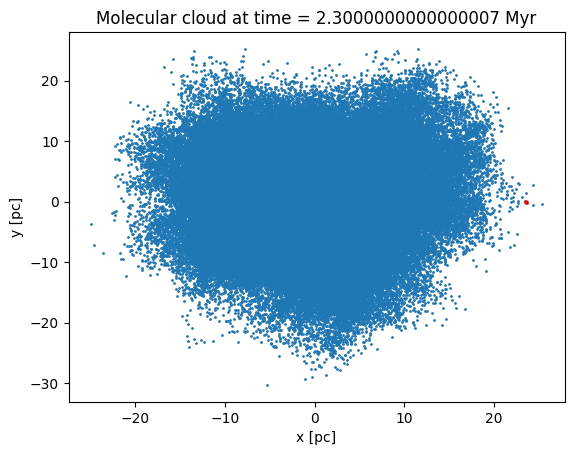

Sink radius [0.192812875235] parsec
Sink in progress at 2.400000000000001  Myr. Now located at [ 25.20819791]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


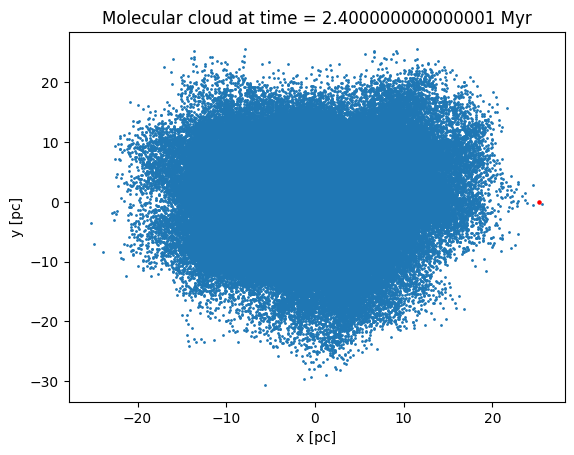

Sink radius [0.192812875235] parsec
Sink in progress at 2.500000000000001  Myr. Now located at [ 26.80311838]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


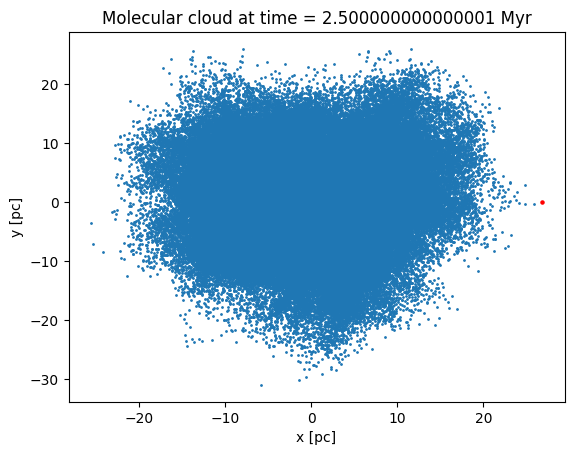

Sink radius [0.192812875235] parsec
Sink in progress at 2.600000000000001  Myr. Now located at [ 28.39754576]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


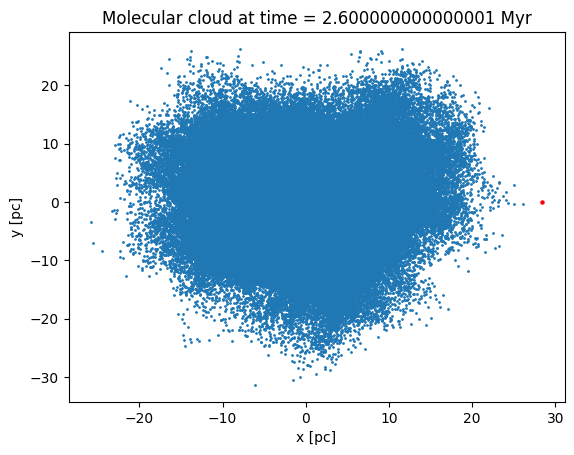

Sink radius [0.192812875235] parsec
Sink in progress at 2.700000000000001  Myr. Now located at [ 29.99153326]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


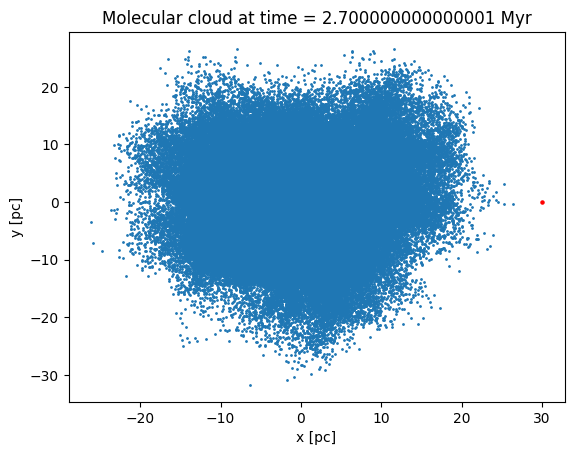

Sink radius [0.192812875235] parsec
Sink in progress at 2.800000000000001  Myr. Now located at [ 31.58512596]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


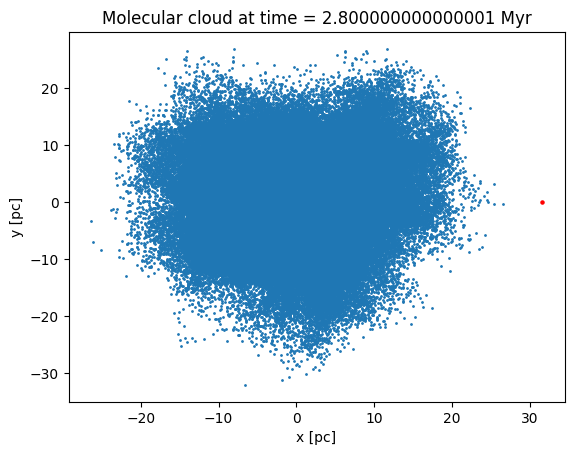

Sink radius [0.192812875235] parsec
Sink in progress at 2.9000000000000012  Myr. Now located at [ 33.17836229]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


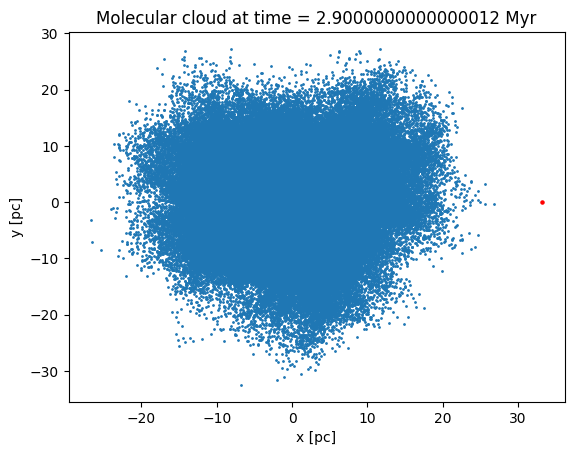

Sink radius [0.192812875235] parsec
Sink in progress at 3.0000000000000013  Myr. Now located at [ 34.7712754]
post accretion 0.896385524423 MSun
203676 number of cloud particles now


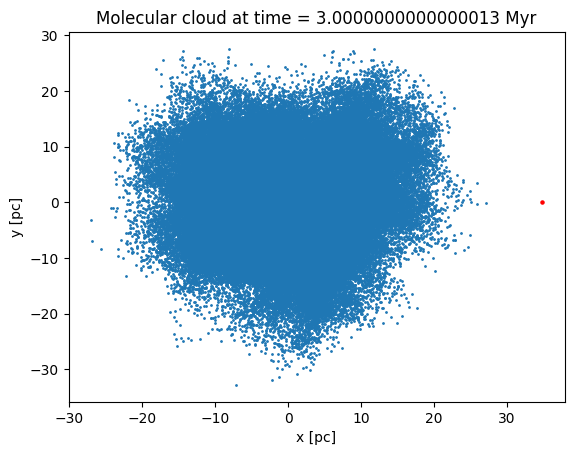

In [15]:
t_end = 3 | units.Myr
model_time = 0 | units.Myr
dt = 0.1 | units.Myr

# L = int(abs(sink.position.sum().value_in(units.pc)))*1.2
# N = 500

sink_mass_snapshots = []

while model_time < t_end:
    # define the accreting radius of the sink particle based on its Bondi radius
    # IMPORTANT: the mass changes after each accretion event
    sink.sink_radius = bondi_radius(sink.mass[0])

    print("Sink radius", sink.sink_radius[0].in_(units.pc))

    print("pre accretion",sink.mass[0])
    
    model_time += dt
    model_time = model_time.round(1)
    # evolve the gravity and hydro codes through our bridge
    gravhydrobridge.evolve_model(model_time)


    # update channels (copy over from the codes.particles to the particle sets)
    channel["to_sink"].copy()
    channel["to_cloud"].copy()

    print("Sink in progress at", model_time.value_in(units.Myr), " Myr. Now located at", sink.x[0].value_in(units.pc), "pc.")
    # add the acretted mass to the sink's total mass
    sink.accrete(particles_cloud)
    # update channels (copy the information from the particle set to the gravity code)
    channel["from_sink"].copy()
    # save the total mass of each step
    sink_mass_snapshots.append(sink.mass[0].value_in(units.MSun))

    print("post accretion",sink.mass[0])
    print(len(particles_cloud.mass), "number of cloud particles now")

    plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc), s = 1)
    plt.scatter(sink.x.value_in(units.pc), sink.y.value_in(units.pc), c = 'red', s = 5)
    plt.title("Molecular cloud at time = " + model_time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()


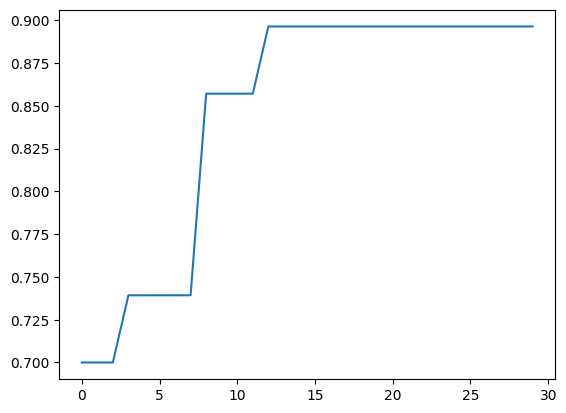

In [17]:
plt.plot(sink_mass_snapshots)
plt.show()

In [ ]:
gravity_code.stop()
hydro_cloud.stop()
gravhydrobridge.stop()